## Hello Team! 
This is our shared Google Colab Document.

Here, we can code stuff, ideas, or do something else.

## Example Implentation of a CNN classifying FashionMNIST images (shoes, jackets, ...)

In [1]:
# LIBRARIES
import torch 
import torch.nn as nn   # NN super class, layer classes (Linear, Conv, Pool, ...)
import torch.nn.functional as F # activation functions  (ReLU, Step, Sigmoid, ...)
import torch.optim as optim # optimizer                  (SGD, Adam, ...)

from torch.utils.data import DataLoader # Dataloader (for automatic batches)
from torchvision import datasets, transforms # datasets (MNIST) & transformations for pre-processing data (convert to Tensor, Normalization)

In [2]:
# HYPERPARAMETER
epochs = 5
batch_size = 64
learning_rate = 0.2

In [3]:
# LOADING DATA
path = 'data/fashion-mnist'

transforms = transforms.Compose([transforms.ToTensor()])

train_data = datasets.FashionMNIST(path,download=True, train= True, transform=transforms)
test_data = datasets.FashionMNIST(path, download=True, train= False, transform=transforms)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

num_classes = len(train_data.classes)

100%|██████████| 26421880/26421880 [00:01<00:00, 15701331.76it/s]


Extracting data/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/fashion-mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305628.64it/s]


Extracting data/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/fashion-mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5123438.11it/s]


Extracting data/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/fashion-mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23806259.09it/s]


Extracting data/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/fashion-mnist/FashionMNIST/raw



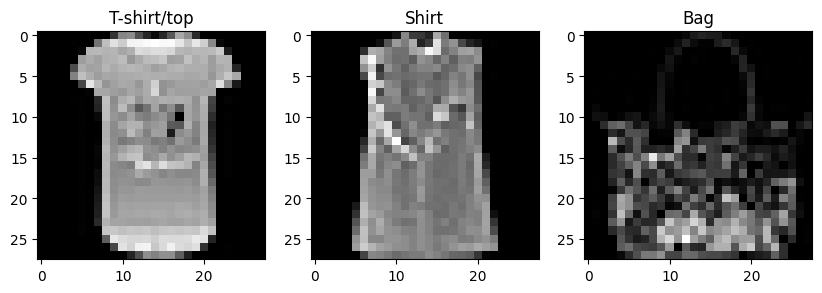

In [71]:
# PLOTTING DATA
import matplotlib.pyplot as plt

# Get one batch of images from train_dataloader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Display three images
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].set_title(f"{test_data.classes[labels[i]]}")
plt.show()

In [7]:
# DETERMINE SIZE OF INPUT LAYER OF 1. FULLY CONNECTED LAYER
images, _ = next(iter(train_dataloader))

# define all other layers
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2)
pool1 = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)
pool2 = nn.MaxPool2d(2,2)

imgs_forwarded = pool2(conv2(pool1(conv1(images))))
img_shape     = imgs_forwarded.size()

fc1_layer_input_size = img_shape[1] * img_shape[2] * img_shape[3] # IMPORTANT FOR THE 1. nn.Linear(in_features=) 
print(f'''Shape is {img_shape}, 
so Fully-Connected Layer input layer has size {img_shape[1]}*{img_shape[2]}*{img_shape[3]}={img_shape[1]*img_shape[2]*img_shape[3]}''') 


Shape is torch.Size([64, 64, 6, 6]), 
so Fully-Connected Layer input layer has size 64*6*6=2304


In [8]:
# CREATE CONV. NEURAL NETWORK
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.conv_layers = nn.Sequential(
        conv1, 
        nn.ReLU(),
        pool1, 

        conv2,
        nn.ReLU(),
        pool2,

        nn.Dropout2d(0.5),
        nn.Flatten()
      )

    self.fc_layers = nn.Sequential(
        nn.Linear(in_features=fc1_layer_input_size, out_features=64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.fc_layers(x)

    # compute probabilities for each class 
    return F.log_softmax(x, -1)

In [19]:
# PLOT 
def plot_loss(losses):
    epochs = range(1, len(losses) + 1)
    
    plt.plot(epochs, losses, label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # set x-axis ticks to integers only
    xint = range(min(epochs), max(epochs)+1)
    plt.xticks(xint)

    plt.legend()
    plt.show()

In [10]:
# FUNCTIONS FOR TRAIN & EVAL
def train(model:nn.Module, optimizer:optim.Optimizer, dataloader:DataLoader, loss_fn):
  model.train()
  n_batches = len(dataloader)

  losses = []

  for i_epoch in range(epochs):
    loss_epoch = 0.0

    for i_batch, (X,y) in enumerate(dataloader):
        # move images to GPU
        X,y = X.to(device), y.to(device)

        # predict
        pred = model(X)

        # calculate loss
        loss = loss_fn(pred, y)
        loss_epoch += loss


        # update weights based on loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print progress
        if i_batch % 250 == 0:
          print(f'Epoch\t{i_epoch+1}/{epochs}\t\tBatch\t{i_batch}/{n_batches}\t({(100. * i_batch / n_batches):.1f}%)\t\tLoss\t{loss:.4f}')

    losses.append(loss_epoch / n_batches)
  return losses 



def test(model:nn.Module, dataloader:DataLoader, loss_fn):
  model.eval()
  num_samples = 0
  num_correct = 0

  with torch.no_grad():
    for _, (X,y) in enumerate(dataloader):
      # move images to GPU
      X,y = X.to(device), y.to(device)

      # predict
      pred = model(X)

      # extract prediction (max. value in tensor)
      _, pred = torch.max(pred, 1)

      # count 
      num_samples += y.size(0)
      num_correct += (pred==y).sum().item()


    acc = 100 * num_correct / num_samples


    print(f'Accuracy is {acc:.2f}%') 

In [11]:
# ACTIVATE GPU / CUDA (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)


# EXECUTE / TRAIN MODEL
my_model = MyCNN().to(device)

optimizer = optim.SGD(my_model.parameters(), lr=learning_rate)
criterion = F.nll_loss

# TRAIN MODEL (TRAIN DATA)
losses = train(model=my_model, optimizer=optimizer, dataloader=train_dataloader, loss_fn=criterion)

Using device:  cuda
Epoch	1/5		Batch	0/938	(0.0%)		Loss	2.3078
Epoch	1/5		Batch	250/938	(26.7%)		Loss	0.8260
Epoch	1/5		Batch	500/938	(53.3%)		Loss	0.5340
Epoch	1/5		Batch	750/938	(80.0%)		Loss	0.3362
Epoch	2/5		Batch	0/938	(0.0%)		Loss	0.5453
Epoch	2/5		Batch	250/938	(26.7%)		Loss	0.5009
Epoch	2/5		Batch	500/938	(53.3%)		Loss	0.3517
Epoch	2/5		Batch	750/938	(80.0%)		Loss	0.4498
Epoch	3/5		Batch	0/938	(0.0%)		Loss	0.5423
Epoch	3/5		Batch	250/938	(26.7%)		Loss	0.3551
Epoch	3/5		Batch	500/938	(53.3%)		Loss	0.3901
Epoch	3/5		Batch	750/938	(80.0%)		Loss	0.4991
Epoch	4/5		Batch	0/938	(0.0%)		Loss	0.3164
Epoch	4/5		Batch	250/938	(26.7%)		Loss	0.2367
Epoch	4/5		Batch	500/938	(53.3%)		Loss	0.2983
Epoch	4/5		Batch	750/938	(80.0%)		Loss	0.3003
Epoch	5/5		Batch	0/938	(0.0%)		Loss	0.4082
Epoch	5/5		Batch	250/938	(26.7%)		Loss	0.3131
Epoch	5/5		Batch	500/938	(53.3%)		Loss	0.2874
Epoch	5/5		Batch	750/938	(80.0%)		Loss	0.2959


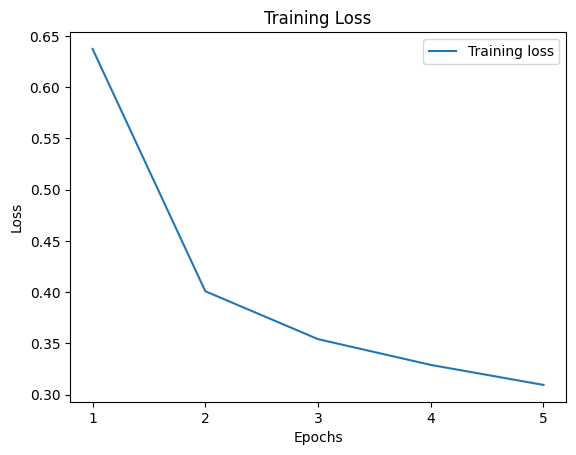

In [20]:
# PLOT LOSS DURING TRAINING
plot_loss(torch.Tensor(losses).cpu())

In [21]:
# TEST MODEL WITH UNSEEN DATA (TEST DATA)

test(model=my_model, dataloader=test_dataloader, loss_fn=criterion)


Accuracy is 85.92%


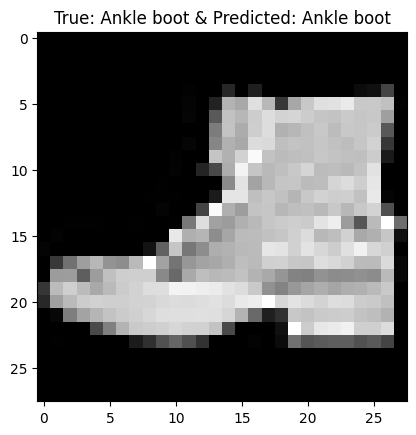

Classification is TRUE


In [69]:
# PREDICT NUMBERS WITH MODEL

# take one img
img, label = next(iter(test_dataloader))
img = img.to(device)[0]
label = label[0]


# predict
my_model.eval()
with torch.no_grad():
  pred = my_model(img.unsqueeze(0))
  _, pred = torch.max(pred.data,dim=1)

plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.title(f'True: {test_data.classes[label.item()]} & Predicted: {test_data.classes[pred.item()]}')
plt.show()

is_true = 'TRUE' if label.item() == pred.item() else 'FALSE'
print(f'Classification is {is_true}')